In [2]:
%matplotlib inline
import pylab as plt
from blimpy import Waterfall
import numpy as np
from scipy import interpolate
import peakutils
import rfi
import turbo_seti
import pandas as pd
import BaselineRemoval
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import scipy
import os
from astropy.time import Time
from astropy import units as u
import matplotlib
import time

In [3]:
def MJD_time(w):
    for key, val in w.file_header.items():
        if key == 'src_raj':
            val = val.to_string(unit=u.hour, sep=':')
        if key == 'src_dej':
            val = val.to_string(unit=u.deg, sep=':')
        if key in ('foff', 'fch1'):
            val *= u.MHz
        if key == 'tstart':
            #print("%16s : %32s" % ("tstart (ISOT)", Time(val, format='mjd').isot))
            key = "tstart (MJD)"
            return  Time(val, format='mjd').isot

In [4]:
path='data/BR/'
files=os.listdir(path)
#files.remove('.ipynb_checkpoints')
len(files)

45

In [5]:
wf=[]
j=0
for i in files:
    #print(j)
    wf.append(Waterfall(path+i))
    j+=1
name=[]
j=0
for i in wf:
    name.append([i.container.f_stop-i.container.f_start,files[j]])
    j+=1
name.sort(reverse=True)
wf=[]
for i in name:
    wf.append(Waterfall(path+i[1]))
# for i in wf:
#     print(i.container.f_start)

In [7]:
a1=0
a2=0
for i in wf:
    if i.container.f_start<=856.0:
        a1+=1
    else:
        a2+=1
print(a1,a2)

42 3


In [9]:
data=pd.DataFrame()
data['source_name']=[]
data['time(MJD)']=[]
data['src_raj']=[]
data['f_range(MHz)']=[]
data['RFI(MHz)']=[]
j=0
for i in wf:
    a=i.header['source_name']
    b=i.header['tstart']
    c=i.header['src_raj']
    d=(i.container.f_begin,i.container.f_end)
    e=rfi.rfi_range(i,dist=10)
    data.loc[j]=[a,b,c,d,e]
    j+=1
    #print(j)
data.to_latex('RFI_BR.tex',index=False)
data.to_csv('RFI_BR.csv',index=False)

In [10]:
a=0
b=0
c=0
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>880)&(j[0]<970)) or ((j[1]>880)&(j[1]<970)):
            a+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1120)&(j[0]<1300)) or ((j[1]>1120)&(j[1]<1300)):
            b+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1400)&(j[0]<1610)) or ((j[1]>1400)&(j[1]<1610)):
            c+=1
            break
print(a,b,c)

43 33 29


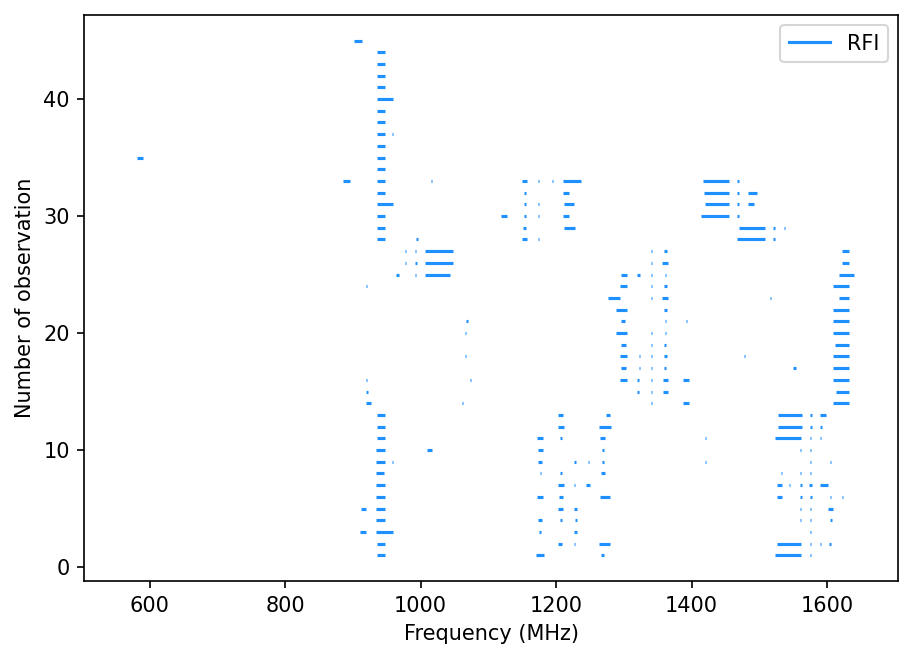

In [14]:
j=1
plt.figure(figsize=(7,5),dpi=150)
for i in data['RFI(MHz)']:
    for k in i:
        plt.hlines(j,k[0],k[1],color='dodgerblue')
    j+=1
plt.plot([],[],color='dodgerblue',label='RFI')
# plt.vlines(880,0,50,'dodgerblue',linestyles='--')
# plt.vlines(960,0,50,'dodgerblue',linestyles='--')
# plt.vlines(1120,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1300,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1400,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1610,0,28,'dodgerblue',linestyles='--')
# plt.bar(700,50,width=312,color='w',hatch='/',label='UHF-band')
# plt.bar(972,50,width=232,color='w',hatch='X',label='UHF and L overlap')
# plt.bar(1400,50,width=624,color='w',hatch="\\",label='L-band')
# plt.text(900,50,str(a)+' obs')
# plt.text(1190,28,str(b)+' obs')
# plt.text(1490,28,str(c)+' obs')
plt.ylabel('Number of observation')
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.savefig('plots/after_mid/RFI_vs_File_BR.pdf')

In [7]:
j=1
plt.figure(figsize=(10,4*len(wf)),dpi=100)
for i in wf:
    plt.subplot(len(wf),1,j)
    f,p,base=rfi.base(i)
    maxi=np.amax(rm)
    multi=1.0
    if maxi>10000:
        multi=multi/10
    thres=multi*rm.std()
    plt.plot(f,base+thres,label='Threshold')
    if i.container.f_start>=856.0:
        plt.text(1128,np.amax(p)*0.025,'L-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    else:
        plt.text(1128,np.amax(p)*0.025,'UHF-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    #plotting
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,'r--',label='Fitted')
    RFI=rfi.rfi_range(i,multi=2.0)
    tot=0
    for k in RFI:
        if k[1]-k[0]>i.header['foff']:
            plt.bar((k[1]+k[0])/2,np.amax(rm),width=k[1]-k[0],color='lime')
        else:
            plt.vlines(k[0],0,np.amax(rm),'lime')
        tot+=(k[1]-k[0])
#     plt.text(1128,np.amax(p)*0.9,
#              str(j)+'Identified RFI covers '+str(np.round(tot/(i.container.f_stop-i.container.f_start)*100,decimals=2))+'% of given bandwidth'
#              ,size=5,ha='center')
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544,1712)
    plt.ylim(-100,np.amax(p)*0.025)
    #plt.yscale('log')
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_BR.pdf',bbox_inches = 'tight')
plt.close()

In [6]:
start=time.time()
j=1
multi=0.8
plt.figure(figsize=(10,4*len(wf)),dpi=100)
for i in wf:
    plt.subplot(len(wf),1,j)
    f,p,base=rfi.base(i)
    test=rfi.rfi_range(i,multi=multi)
    plt.plot(f,p,'k',label='Power')
    plt.plot(f,base,'r--',label='Baseline')
    for k in test:
        if k[1]-k[0]>i.header['foff']:
            plt.bar((k[1]+k[0])/2,np.amax(p-base),width=k[1]-k[0],color='lime')
        else:
            plt.vlines(k[0],0,np.amax(p-base),'lime')
    thres=(p-base).std()*multi/10
    plt.plot(f,base+thres,label='Threshold')
    if i.container.f_start>=856.0:
        plt.text(1128,np.amax(p)*multi/50,'L-Band at '+MJD_time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    else:
        plt.text(1128,np.amax(p)*multi/50,'UHF-Band at '+MJD_time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544,1712)
    plt.ylim(-100,np.amax(p)*multi/50)
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_BR.pdf',bbox_inches = 'tight')
plt.close()
end=time.time()
print('This takes '+str(end-start)+' (s)')

This takes 49.745206117630005 (s)


extracting integration 0...


(-100.0, 2000.0)

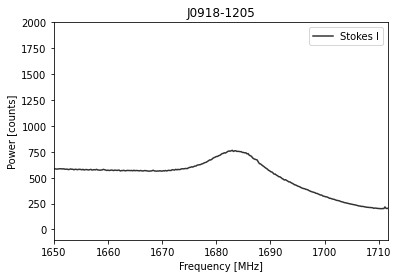

In [26]:
wf[0].plot_spectrum(f_start=1650)
plt.ylim(-100,2000)

In [ ]:
wf[4]